Importing from Libraries

In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


Loading Data

In [103]:
df = pd.read_csv('./IMDb_Movies_India.csv', encoding='ISO-8859-1')
print(df.head())



                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2019)  110 min  Comedy, Romance   
4                   ...And Once Again  (2010)  105 min            Drama   

   Rating Votes            Director       Actor 1             Actor 2  \
0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   

           Actor 3  
0  Rajendra Bhatia  
1    Arvind Jangid  
2       Roy Angana  
3  Siddhant Kapoor  
4    

Informations about Data

In [104]:
print(df.describe())
print(df.dtypes)

            Rating
count  7919.000000
mean      5.841621
std       1.381777
min       1.100000
25%       4.900000
50%       6.000000
75%       6.800000
max      10.000000
Name         object
Year         object
Duration     object
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object


Informations about missing values

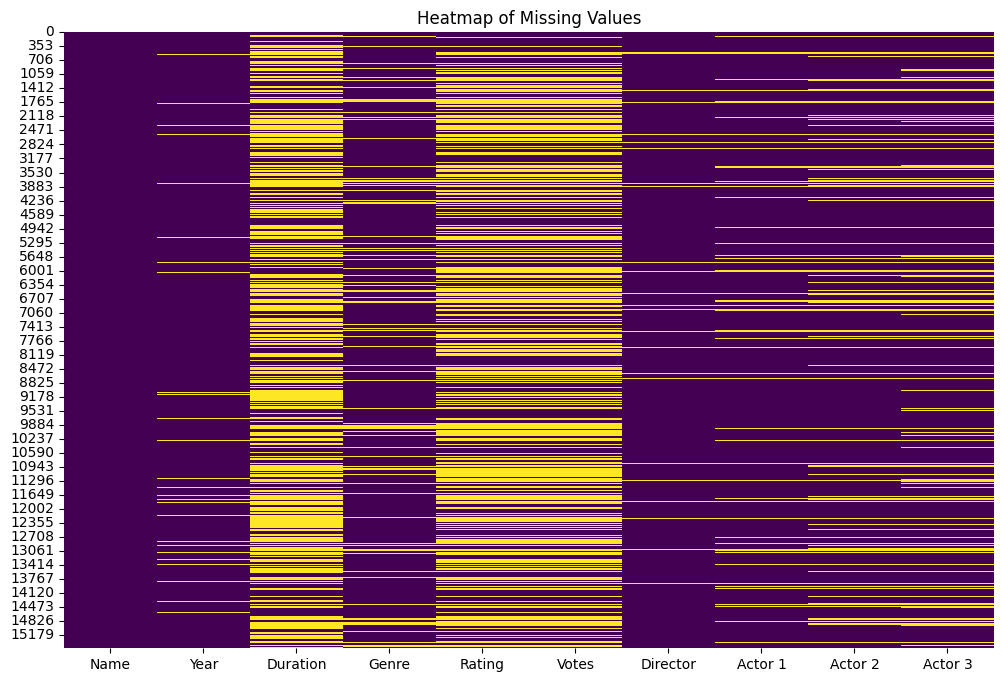

C:\Users\DELL\AppData\Local\Temp\ipykernel_18128\3896278475.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')


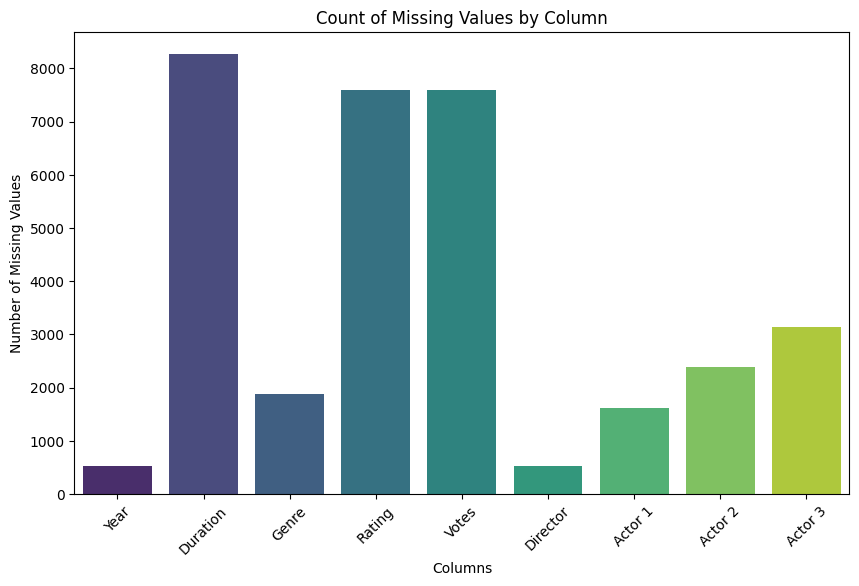

In [105]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()
missing_values = df.isnull().sum()

# Filter only columns with missing values
missing_values = missing_values[missing_values > 0]

# Plot the missing values count
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.title('Count of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.show()

Cleaning the Duration column

In [106]:
df['Duration'] = df['Duration'].str.replace(' min', '').astype(float)


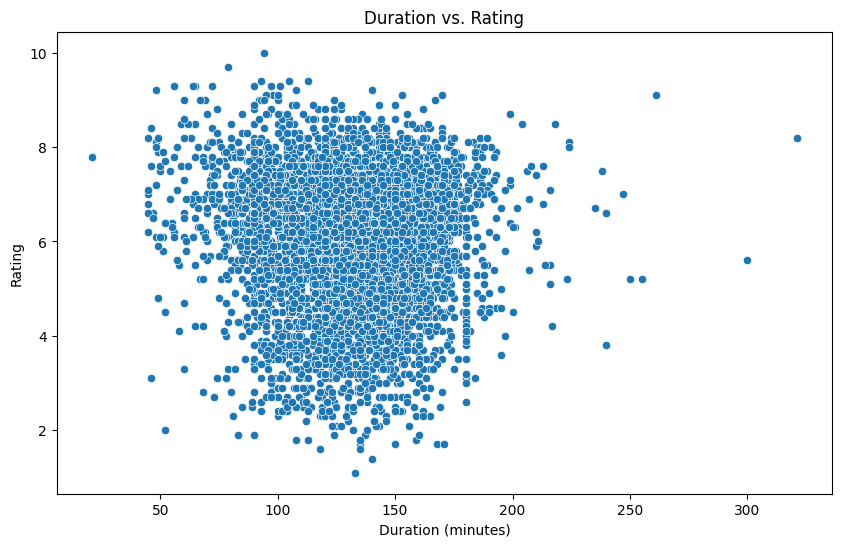

In [107]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration', y='Rating', data=df)
plt.title('Duration vs. Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.show()

In [108]:
missing_count = df['Votes'].isna().sum()
missing_percentage = (missing_count / len(df)) * 100
print(f"Missing values: {missing_count} ({missing_percentage:.2f}%)")

Missing values: 7589 (48.93%)


Cleaning the Votes Column

In [109]:
df['Votes'] = df['Votes'].str.replace(',', '')
def convert_votes(value):
    if pd.isna(value):  # Handle NaN values
        return np.nan
    value = str(value).replace('$', '').strip()  # Remove dollar sign and extra whitespace
    if 'M' in value:
        return float(value.replace('M', '').replace(',', '')) * 1e6  # Convert millions
    elif 'K' in value:
        return float(value.replace('K', '').replace(',', '')) * 1e3  # Convert thousands
    else:
        return float(value.replace(',', ''))  # Convert directly if no special character

df['Votes'] = df['Votes'].apply(convert_votes)

In [110]:
df['Year'] = df['Year'].str.replace(')', '')
df['Year'] = df['Year'].str.replace('(', '').astype(float)



In [111]:
print (df.describe())

               Year     Duration       Rating         Votes
count  14981.000000  7240.000000  7919.000000  7.920000e+03
mean    1987.012215   128.126519     5.841621  2.589791e+03
std       25.416689    28.912724     1.381777  5.910915e+04
min     1913.000000     2.000000     1.100000  5.000000e+00
25%     1968.000000   110.000000     4.900000  1.600000e+01
50%     1991.000000   131.000000     6.000000  5.500000e+01
75%     2009.000000   147.000000     6.800000  4.040000e+02
max     2022.000000   321.000000    10.000000  5.160000e+06


Dropping missing values

In [112]:
df.dropna(inplace=True)


Dropping the Name column as it doesn't influence on anything

In [113]:
df = df.drop(columns=['Name'])


Handling the Categorical column Genre

In [114]:
df['Genre'] = df['Genre'].str.split(', ')
all_genres = set(g for genres in df['Genre'] for g in genres)
for genre in all_genres:
    df[genre] = df['Genre'].apply(lambda x: 1 if genre in x else 0)
df.drop('Genre', axis=1, inplace=True)


Feature engineering / replacing the name of actors and directors by their mean movies ratings

In [115]:
director_mean_rating = df.groupby('Director')['Rating'].transform('mean')
df['Director_encoded'] = director_mean_rating

actor1_mean_rating = df.groupby('Actor 1')['Rating'].transform('mean')
df['Actor1_encoded'] = actor1_mean_rating

actor2_mean_rating = df.groupby('Actor 2')['Rating'].transform('mean')
df['Actor2_encoded'] = actor2_mean_rating

actor3_mean_rating = df.groupby('Actor 3')['Rating'].transform('mean')
df['Actor3_encoded'] = actor3_mean_rating

df.drop(['Actor 1', 'Actor 2', 'Actor 3', 'Director'], axis=1, inplace=True)

Splitting data to training and testing data

In [116]:
X = df.drop('Rating', axis=1)
y = df['Rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Building our model which the Light Gradient Boosting Model and adjusting hyperparmeters by a Grid Search 

In [117]:
from lightgbm import LGBMRegressor


model = LGBMRegressor(random_state=42)
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__num_leaves': [31, 50, 70],
    'regressor__max_depth': [-1, 10, 20]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best R^2 Score: {grid_search.best_score_:.3f}')
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)




Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Unknown parameter: regressor__learning_rate
[LightGBM] [Warning] Unknown parameter: regressor__max_depth
[LightGBM] [Warning] Unknown parameter: regressor__n_estimators
[LightGBM] [Warning] Unknown parameter: regressor__num_leaves
[LightGBM] [Warning] Unknown parameter: regressor__learning_rate
[LightGBM] [Warning] Unknown parameter: regressor__max_depth
[LightGBM] [Warning] Unknown parameter: regressor__n_estimators
[LightGBM] [Warning] Unknown parameter: regressor__num_leaves
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 4527, number of used features: 27
[LightGBM] [Info] Start training from score 5.892931
Best Parameters: {'regressor_

Evaluating our model by Squared Error and R square

In [118]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.3f}')
print(f'R^2 Score: {r2:.3f}')


Mean Squared Error: 0.323
R^2 Score: 0.825


Our model has an R square of 0.825 and that is mean it's good enough ! 💪